In [23]:
#pip install numpy opencv-python matplotlib drawSvg affine

In [24]:
#pip install https://cdn.evilmadscientist.com/dl/ad/public/AxiDraw_API.zip

In [25]:
#pip install git+https://github.com/abey79/vpype.git#egg=vpype

In [8]:
import sys
print(sys.executable)

/home/malboy/code/plotting-architecture/venv/bin/python


In [2]:
# link: https://inconvergent.net/2018/impossible-architecture/
# add draw thick lines to svg draw?

In [27]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [28]:
import random

def get_random_id_str():
    return f'{random.randint(0, 16**8):0>8x}'

def id_to_number(id_str):
    return int(id_str, 16)

In [29]:
import drawSvg as draw_svg_lib
from affine import Affine
from IPython.display import SVG, display

class SvgDraw:
    def __init__(self, size=1000, line_thickness=2, color=(0,0,0)):
        self.drawing = draw_svg_lib.Drawing(size, size, origin=(0,0))
        self.size = size
        self.args = {"fill":"none", "stroke": "#{0:02x}{1:02x}{2:02x}".format(*color), "stroke_width": line_thickness}
        self.t = Affine.identity()

    def save_transform(self):
        self.save_transform_mat = self.t
    
    def restore_transform(self):
        self.t = self.save_transform_mat

    def scale(self, x, y=None):
        y = x if y is None else y
        self.t *= Affine.scale(x, y)

    def translate(self, x, y):
        self.t *= Affine.translation(x, y)

    def show(self):
        display(SVG(data=self.drawing.asSvg()))

    def save(self, path):
        self.drawing.saveSvg(path)

    def line(self, p1, p2):
        self.drawing.append(draw_svg_lib.Line(*(p1.tolist()*self.t), *(p2.tolist()*self.t), **self.args))

    def polyline(self, pts, connect_endings=True):
        pts = np.array([p.tolist()*self.t for p in pts])
        self.drawing.append(draw_svg_lib.Lines(*pts.flatten(), close=connect_endings, **self.args))

    def polylines(self, pts_list, connect_endings=True):
        [self.polyline(pts, connect_endings) for pts in pts_list]

    def circle(self, p, radius):
        self.drawing.append(draw_svg_lib.Circle(*(p.tolist()*self.t), radius*self.t.a, **self.args))
        return self

    def as_svg(self):
        return self.drawing.asSvg()

In [30]:
def add_side(a, count):
    if count == 0:
        return a
    
    i = np.random.choice(len(a["lines"]))
    p1 = a["lines"][i]
    p2 = a["lines"][(i+1)%len(a["lines"])]
    
    angle = np.arctan2(*(p1-p2))
    
    if np.random.uniform(0,1) < 0.2:
        r = [np.random.uniform(10,150), np.random.uniform(10,150)]
        diff1 = np.array([np.cos(angle)*r[0], -np.sin(angle)*r[0]])
        diff2 = np.array([np.cos(angle)*r[1], -np.sin(angle)*r[1]])
        new_points = [p1+diff1, p2+diff2]

    else:
        r = np.random.uniform(50,100)
        diff = np.array([np.cos(angle)*r, -np.sin(angle)*r])
        new_points = [p1+diff, p2+diff]

    a["lines"] = np.concatenate((a["lines"][:i+1], new_points, a["lines"][i+1:]))

    mp = np.array([p1+(p2-p1)/2])
    a["mid_points"] = mp if len(a["mid_points"])==0 else np.concatenate((a["mid_points"], mp))

    box = np.array([[p1, new_points[0], new_points[1], p2]])
    a["box"] = box if len(a["box"])==0 else np.concatenate((a["box"], box))

    if count>1:
        return add_side(a, count-1)
    
    return a

def new_a():
    return {"lines": np.array([[300, 300], [300, 700], [700, 700], [700, 300]]), "mid_points": [], "box": []}

def get_mid_point(p1, p2):
    return p1+(p2-p1)/2

def get_step_lines(box, dx):
    if np.linalg.norm(box[0]-box[1]) < np.linalg.norm(box[1]-box[2]):
        box = np.roll(box, 1, 0)

    distance = np.linalg.norm(get_mid_point(box[0], box[3])-get_mid_point(box[1], box[2]))

    num_of_lines = int(distance/dx)
    dp0 = (-box[0]+box[1])/num_of_lines
    dp3 = (-box[3]+box[2])/num_of_lines
    step_lines = []
    for i in range(0, num_of_lines+1):
        p0 = box[0] + i* dp0
        p3 = box[3] + i* dp3
        step_lines.append(np.array([p0, p3]))
        
    return step_lines

def get_normal_angle_to_line(p1, p2):
    return np.arctan2(*(p1-p2))

def radiant_move(mid, angle, distance):
    return mid + np.array([np.cos(angle)*distance, -np.sin(angle)*distance])

def create_thick_line_with_multiple_lines(pts, line_type_name, line_count_on_each_side, dx):
    
    if line_type_name=="outter":
        all_lines = [pts]
        for d in np.arange(dx, line_count_on_each_side*dx+0.000001, dx):
            additional_line = []
            for p1, p2 in zip(pts, np.roll(pts, 1, 0)):
                n12 = get_normal_angle_to_line(p1,p2)
                additional_line.extend([radiant_move(p2, n12, d), radiant_move(p1, n12, d)])
            all_lines.append(np.array(additional_line))

    elif line_type_name=="around":
        all_lines = []
        max_dist = line_count_on_each_side*dx
        for p1, p2 in zip(pts, pts[1:]):
            # die rects werden von beiden Seiten einmal gemahlt, nacheinander... das sollte so nicht sein
            n12 = get_normal_angle_to_line(p1,p2)
            for d in np.arange(-max_dist, 0, dx):
                outter_rect = [
                    radiant_move(p2, n12, -d), radiant_move(p1, n12, -d),
                    radiant_move(p1, n12, d), radiant_move(p2, n12, d)]
                all_lines.append(np.array(outter_rect))

    return all_lines

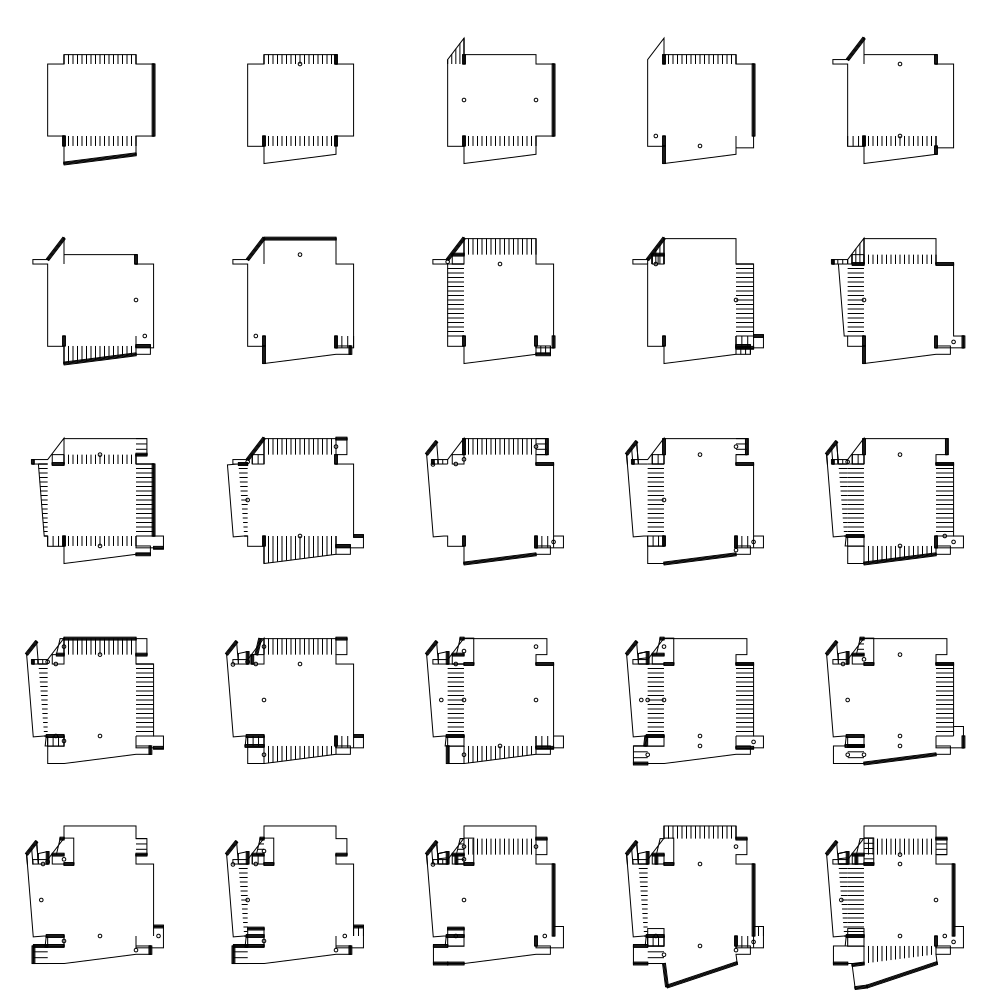

In [41]:
def draw_a(draw, a, outter_points=False, draw_mid_points=0.2, draw_thick_line=0.2, draw_steps=0.2):
    draw.polyline(a["lines"])

    if outter_points:
        for p in a["lines"]:
            draw.circle(p, 5)
    
    for p1, p2 in zip(a["lines"], np.roll(a["lines"], 1, 0)):
        if np.random.uniform(0,1) < draw_thick_line:
            for line12 in create_thick_line_with_multiple_lines(np.array([p1,p2]), "around", 2, 4):
                draw.polyline(line12)

    for p in a["mid_points"]:
        if np.random.uniform(0,1) < draw_mid_points:
            draw.circle(p, 10)
    
    for box in a["box"]:
        if np.random.uniform(0,1) < draw_steps:
            for step_line in get_step_lines(box, 25):
                draw.polyline(step_line, False)

def draw_single(iterations=15, scale=1, outter_points=False, draw_mid_points=0.2, draw_thick_line=0.2, draw_steps=0.2):
    draw = SvgDraw()
    draw.translate(500, 500)
    draw.scale(scale)
    draw.translate(-500, -500)
    a = add_side(new_a(), iterations)
    draw_a(draw, a, outter_points, draw_mid_points, draw_thick_line, draw_steps)
    return draw

def draw_grid(draw_count_per_axis=5, scale=0.13, outter_points=False, draw_mid_points=0.2, draw_thick_line=0.2, draw_steps=0.2, iterative=True):
    draw = SvgDraw(line_thickness=1)
    #q = -1
    #draw.polyline(np.array([[0+q,0+q], [0+q,1000-q], [1000-q,1000-q], [1000-q,0+q]]), connect_endings=True)

    draw.translate(500, 500)
    draw.scale(scale)
    draw.translate(-500, -500)

    border = 0
    dxy = (1000-2*border)/(draw_count_per_axis)/scale
    grid = [[(draw_count_per_axis-i-1),j] for i in range(draw_count_per_axis) for j in range(draw_count_per_axis)]

    if iterative:
        a = add_side(new_a(), 5)

    for i, j in grid:
        draw.save_transform()
        draw.translate((j-0.5*(draw_count_per_axis-1))*dxy, (i-0.5*(draw_count_per_axis-1))*dxy)
        if iterative:
            draw_a(draw, a, outter_points, draw_mid_points, draw_thick_line, draw_steps)
            add_side(a, 1)
        else:
            a = add_side(new_a(), 10)
            draw_a(draw, a, outter_points, draw_mid_points, draw_thick_line, draw_steps)
        draw.restore_transform()    
        

    return draw

def save_images(image_count, dir_path):
    os.mkdir(dir_path)
    for _ in range(image_count):
        id_str = get_random_id_str()
        np.random.seed(id_to_number(id_str))
        draw = draw_grid(draw_count_per_axis=5, scale=0.18, draw_thick_line=0.2, draw_mid_points=0.2, draw_steps=0.2)
        #draw.polyline(np.array([[0,0], [0,1000], [1000,1000]]), connect_endings=True)
        draw.save(os.path.join(dir_path, id_str + ".svg"))

#np.random.seed(412313)
#draw = draw_single(iterations=15, scale=0.2, draw_thick_line=0.2, draw_mid_points=0.2, draw_steps=0.2)
draw = draw_grid(draw_count_per_axis=5, scale=0.18, draw_thick_line=0.2, draw_mid_points=0.2, draw_steps=0.2, iterative=True)
draw.show()
#draw.save("temp.svg")
#save_images(100, "test2")

In [49]:
svg_path = "/home/malboy/Desktop/plotting_architectures_good_ones/32c9e239.svg"
!vpype read "$svg_path" scale 1.0 1.0 multipass --count 2 write --page-format 297x297mm --landscape --center plot.svg
!axicli plot.svg -vg3 --report_time -o preview.svg --model 2

Estimated print time: 26:05 (minutes, seconds)
Length of path to draw: 23.76 m.
Pen-up travel distance: 10.25 m.
Total movement distance: 34.01 m.
This estimate took: 0:00:01 (Hours, minutes, seconds)


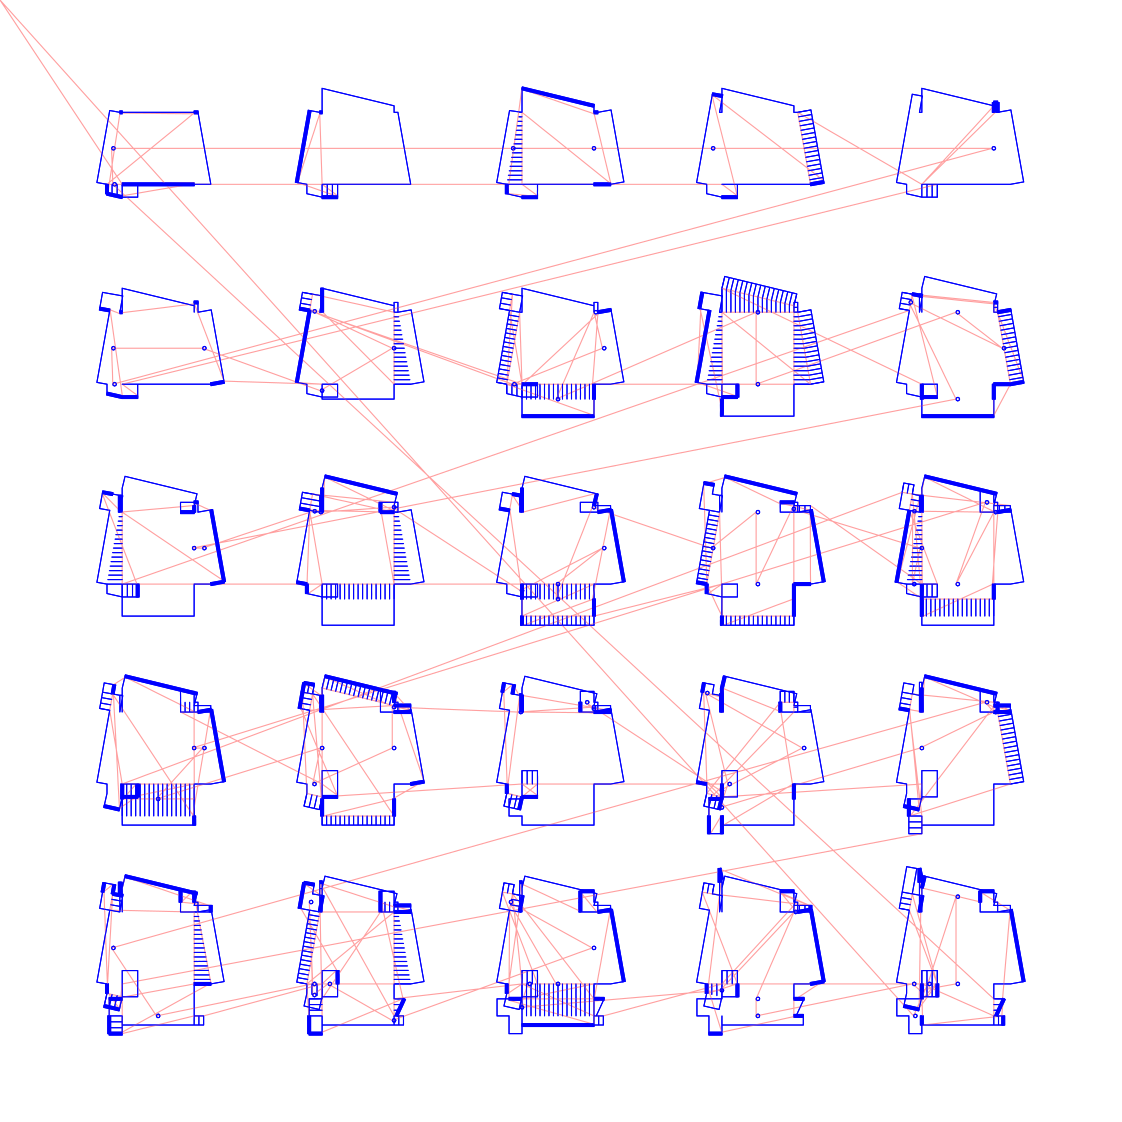

In [50]:
display(SVG(filename="preview.svg"))

In [51]:
!axicli plot.svg --model 2
!axicli -m align

In [292]:
!rm temp.svg plot.svg preview.svg

In [189]:
!axicli -m align

In [46]:
!axicli -m toggle

In [ ]:
from IPython.lib import backgroundjobs as bg
jobs = bg.BackgroundJobManager()

def printfunc(interval=1, reps=5):
    for n in range(reps):
        time.sleep(interval)
        print('In the background... %i' % n)
        sys.stdout.flush()
    print('All done!')
    sys.stdout.flush()